# PTB-XL Dataset Cleaning Filtering

## LIbraries and main functions

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.io.wavfile
import scipy.signal

In [2]:
import ecg_plot

ModuleNotFoundError: No module named 'ecg_plot'

In [2]:
plt.rcParams["figure.figsize"] = (20,10)

## Dataset
- [PTB-XL, a large publicly available electrocardiography dataset](https://physionet.org/content/ptb-xl/1.0.1/)

**Abstract**

- 21,837 clinical 12-lead ECGs from 18,885 patients of 10 second length. 
- Gender: 52% are male and 48% are female 
- Ages covering the whole range from 0 to 95 years (median 62 and interquantile range of 22)
- WaveForm DataBase (WFDB) format with 16 bit precision at a resolution of 1μV/LSB and a sampling frequency of 500Hz (records500/). For the user’s convenience we also release a downsampled versions of the waveform data at a sampling frequency of 100Hz (records100/).
- The raw waveform data was annotated by up to two cardiologists, who assigned potentially multiple ECG statements to each record. 
- The in total 71 different ECG statements conform to the SCP-ECG standard and cover diagnostic, form, and rhythm statements. 
- The dataset is complemented by extensive metadata on demographics, infarction characteristics, likelihoods for diagnostic ECG statements as well as annotated signal properties.

**Data Acquisition**
- Raw signal data was recorded and stored in a proprietary compressed format. 
- For all signals, we provide the standard set of 12 leads (I, II, III, AVL, AVR, AVF, V1, ..., V6) with reference electrodes on the right arm.
- The corresponding general metadata (such as age, sex, weight and height) was collected in a database.
- Each record was annotated with a report string (generated by cardiologist or automatic interpretation by ECG-device) which was converted into a standardized set of SCP-ECG statements (scp_codes). 
- For most records also the heart’s axis (heart_axis) and infarction stadium (infarction_stadium1 and infarction_stadium2, if present) were extracted.

**Data Preprocessing**
- ECGs and patients are identified by unique identifiers (ecg_id and patient_id). 
- Personal information in the metadata, such as names of validating cardiologists, nurses and recording site (hospital etc.) of the recording was pseudonymized. 
- The date of birth only as age at the time of the ECG recording, where ages of more than 89 years appear in the range of 300 years in compliance with HIPAA standards. 
- Furthermore, all ECG recording dates were shifted by a random offset for each patient. The ECG statements used for annotating the records follow the SCP-ECG standard.

**Records - Superclass:	Description**
- 9,528	- NORM: Normal ECG
- 5,486	- MI: Myocardial Infarction
- 5,250	- STTC: ST/T Change
- 4,907	- CD: Conduction Disturbance
- 2,655	- HYP: Hypertrophy

## Filtering and balancing

In [3]:
df = pd.read_csv("ECG_Rhythm_Lead_I.csv")
df.shape

(21837, 1007)

In [4]:
del df["Unnamed: 0"]

In [5]:
df.head(2)

,ecg_id,age,sex,height,weight,rhythm_diag,0,1,2,3,...,990,991,992,993,994,995,996,997,998,999
0,1,56.0,1,NaN,63.0,SR,-0.119,-0.116,-0.120,-0.117,...,0.198,0.194,0.115,0.107,0.107,0.106,0.090,0.069,0.086,0.022
1,2,19.0,0,NaN,70.0,OTHER,0.004,-0.020,-0.053,-0.056,...,-0.035,-0.045,0.004,0.044,0.507,0.554,0.316,0.121,-0.326,-0.348


In [6]:
df = df.loc[df.rhythm_diag != 'OTHER']
df.shape

(18296, 1006)

In [7]:
df.rhythm_diag.value_counts()

SR      16782
AFIB     1514
Name: rhythm_diag, dtype: int64

In [8]:
df.replace({'rhythm_diag': {'SR': 0, 'AFIB': 1}}, inplace=True)
df.rhythm_diag.value_counts()

0    16782
1     1514
Name: rhythm_diag, dtype: int64

In [9]:
from sklearn.utils import resample

In [10]:
df_minority = df[df['rhythm_diag']==1]
df_majority = df[df['rhythm_diag']==0]

In [11]:
maj_class = resample(df_majority,
                     replace=True,
                     n_samples=1514,
                     random_state=123)

In [12]:
maj_class.shape

(1514, 1006)

In [13]:
df=pd.concat([df_minority,maj_class])
df.shape

(3028, 1006)

In [14]:
df.rhythm_diag.value_counts()

0    1514
1    1514
Name: rhythm_diag, dtype: int64

In [15]:
df[df.rhythm_diag == 0]['age'].mean()

57.76275679257787

In [16]:
df[df.rhythm_diag == 1]['age'].mean()

70.79839249832551

In [17]:
X = df.drop(['ecg_id', 'age', 'sex', 'height', 'weight', 'rhythm_diag'], axis=1).values
y = df.rhythm_diag.values
X.shape, y.shape

((3028, 1000), (3028,))

In [18]:
X.max(), X.min(), X.mean()

(4.398, -4.729, -0.000958540620871863)

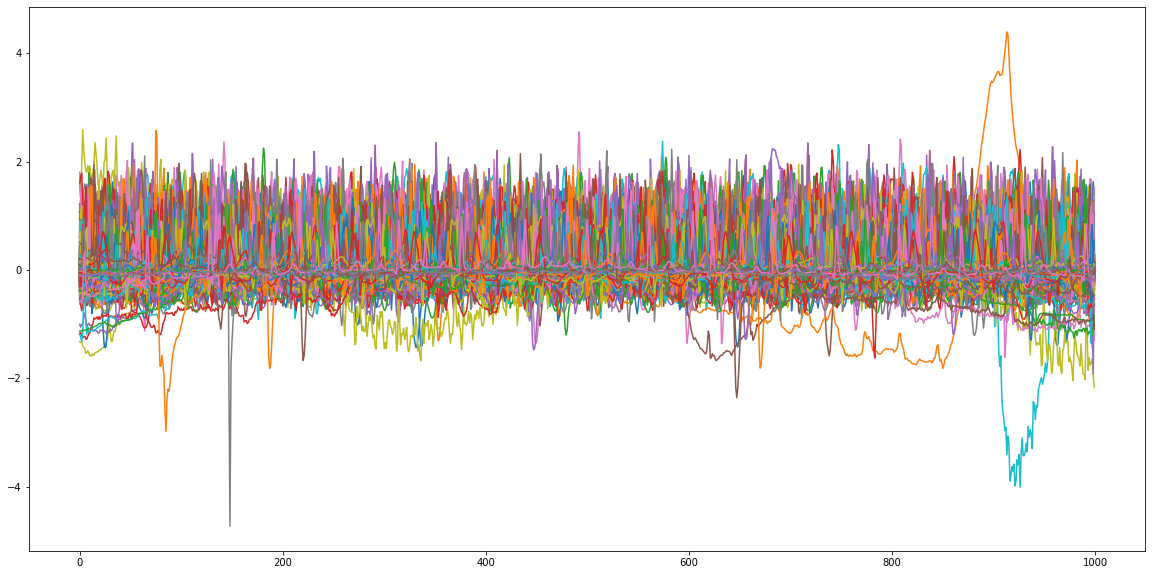

In [20]:
for i in range(len(X)): plt.plot(X[i])

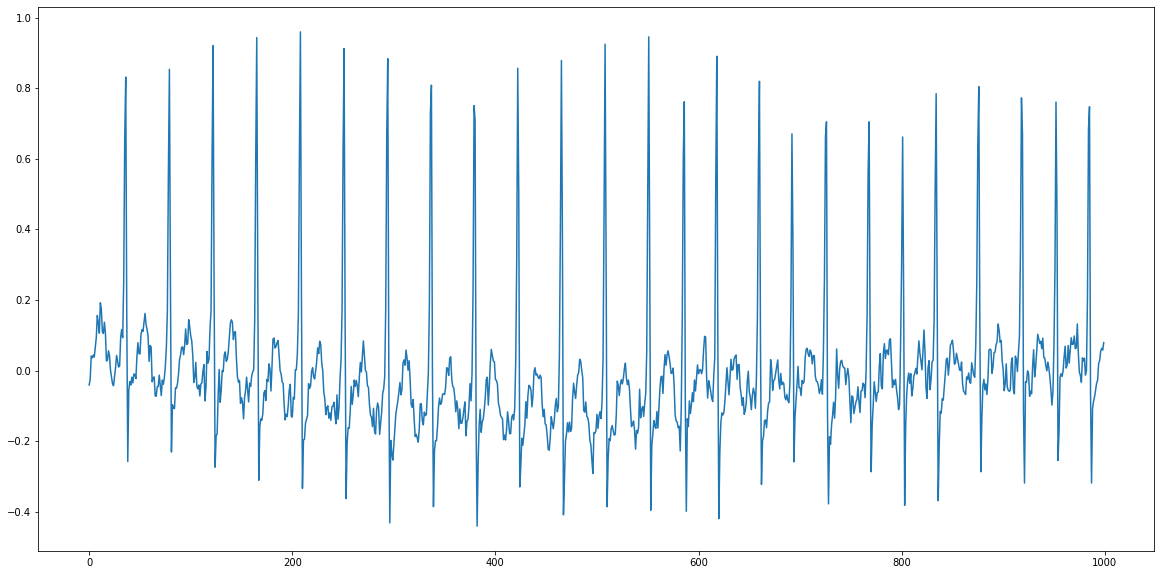

In [19]:
plt.plot(X[0]);

## Data Filter (DPS)

In [44]:
from scipy import signal
from scipy.signal import butter, iirnotch, lfilter

In [20]:
b, a = scipy.signal.butter(5, 0.5)
filtered = scipy.signal.filtfilt(b, a, X[0])

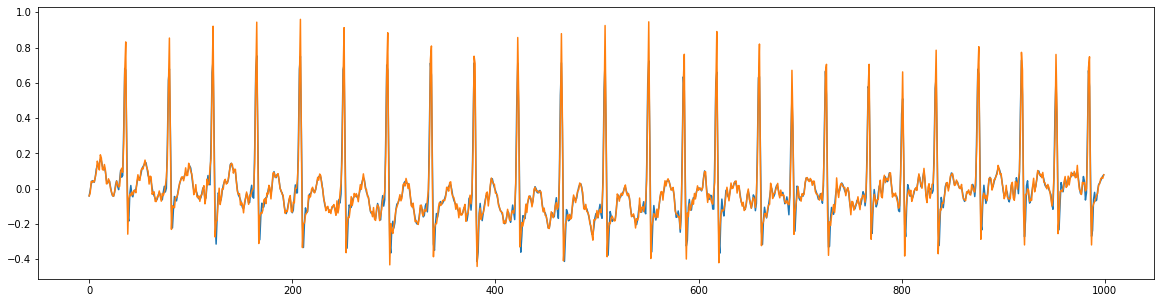

In [26]:
plt.figure(figsize=(20, 5))
#plt.plot(sig[0:slice],label="raw signal")
plt.plot(filtered)
plt.plot(X[0]);

In [39]:
windowSize = 8
window = np.hanning(windowSize)
window = window / window.sum()

# filter the data using convolution
filtered = np.convolve(window,X[0], mode='valid')

Text(0.5, 1.0, 'Filtered')

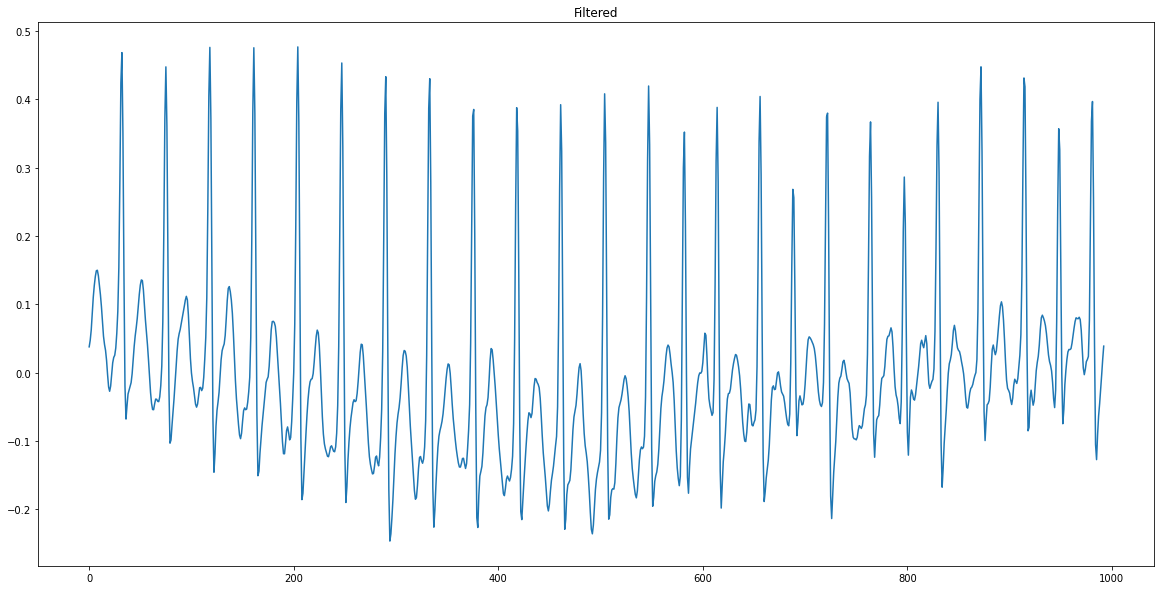

In [40]:
plt.plot(filtered)
plt.title("Filtered")

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html

In [41]:
def plot_filter(b, a):
    w, h = signal.freqs(b, a)
    plt.figure(figsize=(10, 5))
    plt.semilogx(w, 20 * np.log10(abs(h)))
    plt.title('Butterworth filter frequency response')
    plt.xlabel('Frequency [radians / second]')
    plt.ylabel('Amplitude [dB]')
    plt.margins(0, 0.1)
    plt.grid(which='both', axis='both')
    plt.axvline(100, color='green') # cutoff frequency
    plt.show()

In [42]:
def plot_signal_filter(sig, btype, Wn, fs=100, N=5, slice=-1):
    sos = signal.butter(N, Wn, btype, fs=100, output='sos')
    filtered = signal.sosfilt(sos, sig)
    plt.figure(figsize=(20, 5))
    plt.plot(sig[0:slice],label="raw signal")
    plt.plot(filtered[0:slice],label=btype)
    plt.legend();

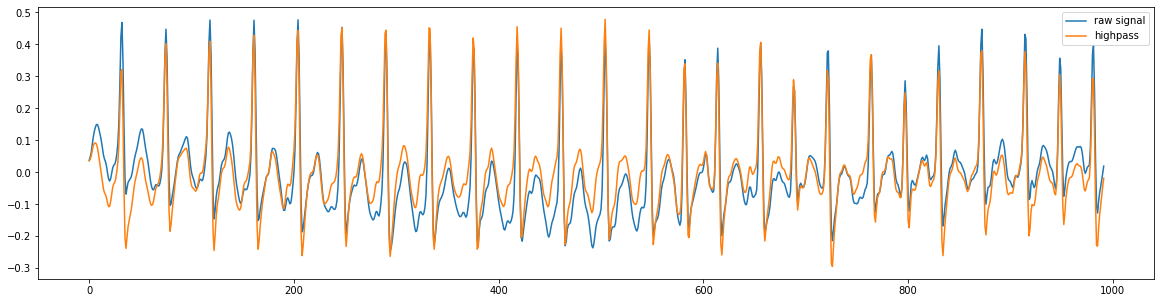

In [45]:
plot_signal_filter(filtered, 'highpass', 0.5)

Text(0.5, 1.0, 'Filtered')

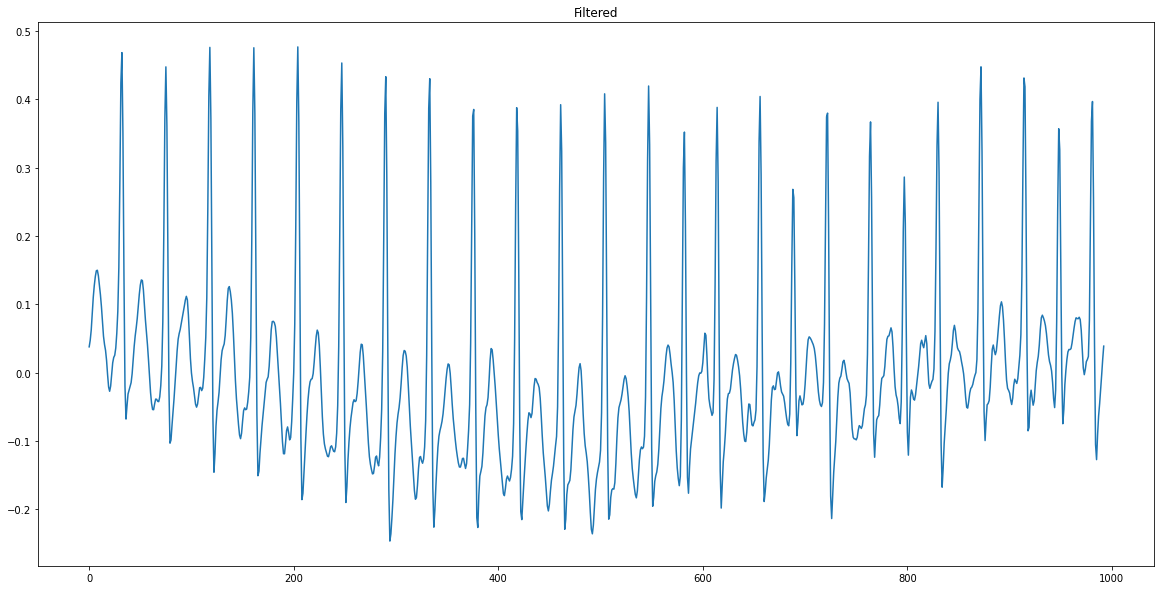

In [46]:
plt.plot(filtered)
plt.title("Filtered")

In [52]:
def plot_signal_filter_2(sig, btype, Wn, fs=100, N=5, slice=-1):
    sos = signal.butter(N, Wn, btype, fs=100, output='sos')
    filtered = signal.sosfilt(sos, sig)
    plt.figure(figsize=(20, 5))
    plt.plot(filtered[0:slice],label=btype)
    plt.legend();

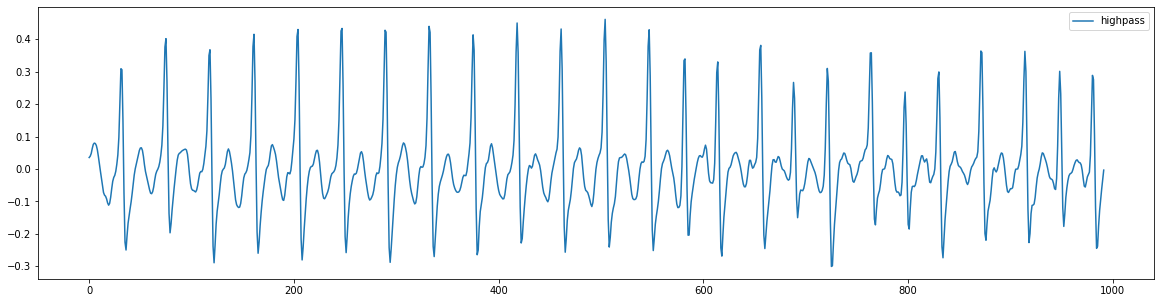

In [63]:
plot_signal_filter_2(filtered, 'highpass', 0.67)

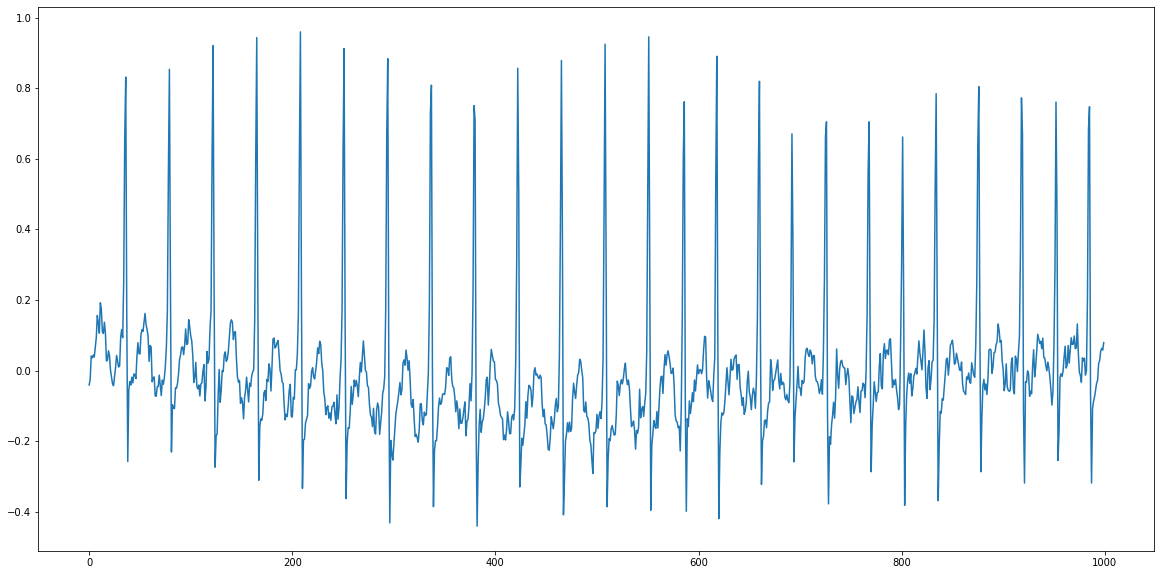

In [64]:
plt.plot(X[0]);

In [65]:
b, a = scipy.signal.butter(5, [.5, 49], 'band')
filteredBandPass = scipy.signal.lfilter(b, a, filtered)
plt.plot(filteredBandPass[0:slice])

ValueError: Digital filter critical frequencies must be 0 < Wn < 1

In [60]:
plot_signal_filter_2(filtered, 'lowpass', 50)

ValueError: Digital filter critical frequencies must be 0 < Wn < fs/2 (fs=100 -> fs/2=50.0)

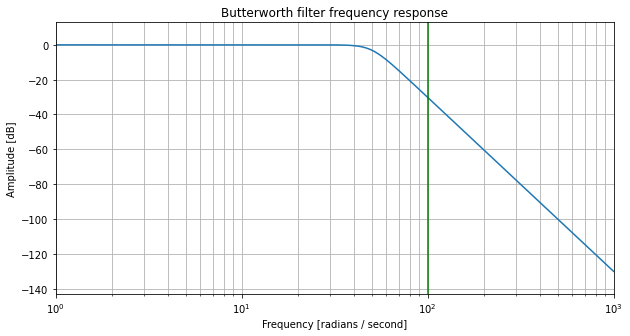

In [25]:
N  = 5            # filter order  - Order of five works well with ECG signals
Wn = 50           # critical frequency
fs = 100          # sample frequency
btype = 'lowpass' # filter type: 'lowpass', 'highpass', 'bandpass', 'bandstop'

b, a = butter(N, Wn, btype, fs)
plot_filter(b, a)

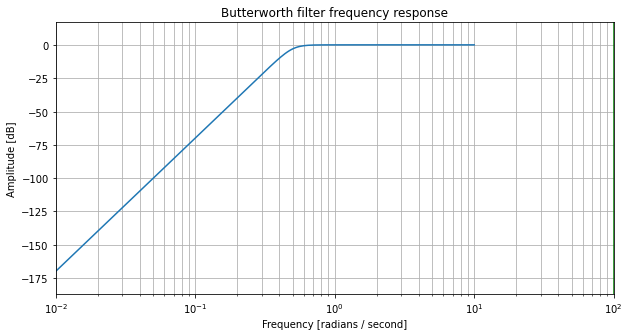

In [26]:
N  = 5             # filter order
Wn = 0.5            # critical frequency
fs = 100           # sample frequency
btype = 'highpass' # filter type: 'lowpass', 'highpass', 'bandpass', 'bandstop'

b, a = butter(N, Wn, btype, fs)
plot_filter(b, a)

`It’s recommended to use second-order sections format when filtering, to avoid numerical error with transfer function (ba) format)`

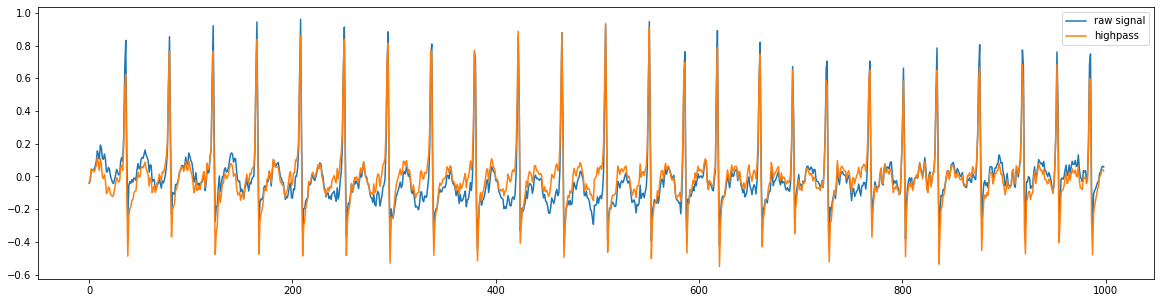

In [31]:
# HighPass Filter: 0.5Hz
plot_signal_filter(X[0], 'highpass', 0.67)

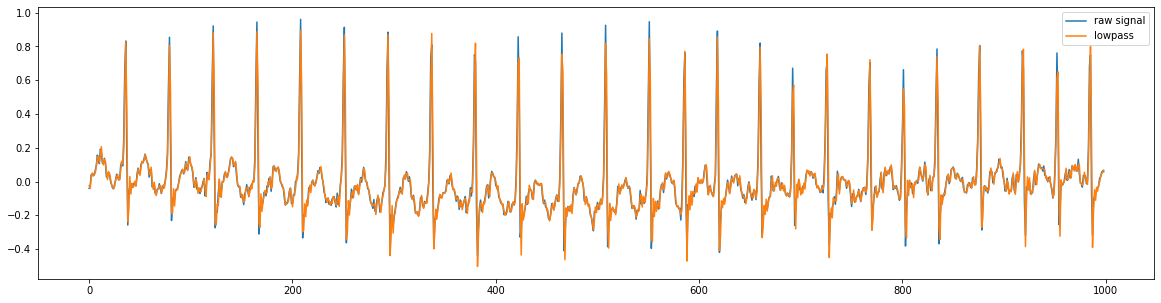

In [32]:
# HighPass Filter: 45Hz
plot_signal_filter(X[0], 'lowpass', 45)

In [33]:
# HighPass Filter: 0.5Hz
sig = X[0]
high = signal.butter(5, 0.67, 'hp', fs=100, output='sos')
high_filtered = signal.sosfilt(high, sig)
low = signal.butter(5, 49, 'low', fs=100, output='sos')
filtered = signal.sosfilt(low, high_filtered)

<Figure size 1440x720 with 0 Axes>

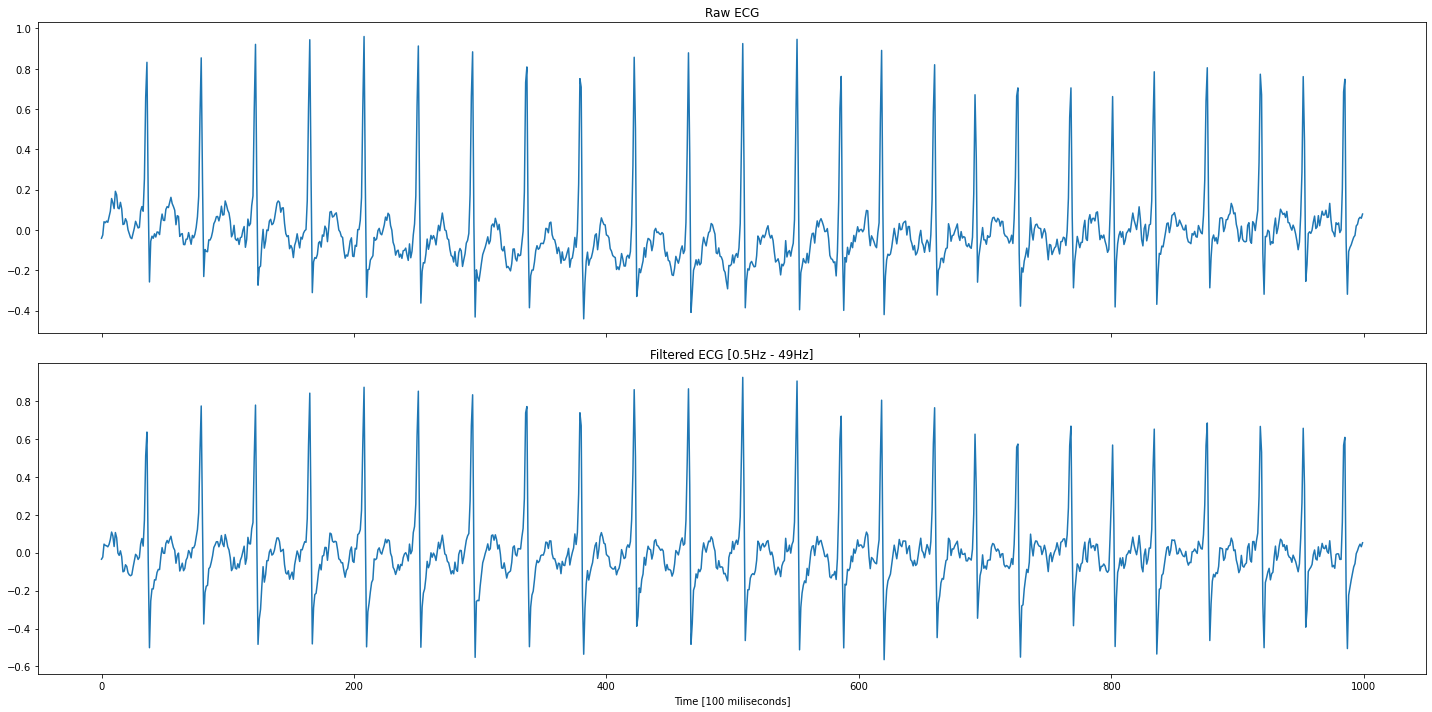

In [34]:
plt.figure(figsize=(20, 10))
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.set_title('Raw ECG')
ax1.plot(sig);
ax2.set_title('Filtered ECG [0.5Hz - 49Hz]')
ax2.plot(filtered);
ax2.set_xlabel('Time [100 miliseconds]');
plt.tight_layout()
plt.show()

## Other Filtering

In [355]:
# A high pass filter allows frequencies higher than a cut-off value
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5*fs
    normal_cutoff = cutoff/nyq
    b, a = butter(order, normal_cutoff, btype='high',
                  analog=False, output='ba')
    return b, a

In [356]:
## A low pass filter allows frequencies lower than a cut-off value
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5*fs
    normal_cutoff = cutoff/nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False, output='ba')
    return b, a

In [357]:
def notch_filter(cutoff, q):
    nyq = 0.5*fs
    freq = cutoff/nyq
    b, a = iirnotch(freq, q)
    return b, a

def highpass(data, fs, order=5):
    b,a = butter_highpass(cutoff_high, fs, order=order)
    x = lfilter(b,a,data)
    return x

def lowpass(data, fs, order =5):
    b,a = butter_lowpass(cutoff_low, fs, order=order)
    y = lfilter(b,a,data)
    return y

def notch(data, powerline, q):
    b,a = notch_filter(powerline,q) # powerline = 60
    z = lfilter(b,a,data)
    return z

def final_filter(data, fs, order=5):
    b, a = butter_highpass(cutoff_high, fs, order=order)
    x = lfilter(b, a, data)
    d, c = butter_lowpass(cutoff_low, fs, order = order)
    y = lfilter(d, c, x)
    f, e = notch_filter(powerline, 30)
    z = lfilter(f, e, y)     
    return z